In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import nltk
nltk.download('stopwords')
!pip install np_utils==0.5.12.1

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.5.12.1-py3-none-any.whl size=57115 sha256=d2b8f85734170b8f0c6abdd51714abd6e3667993c165993ba59dc911f09aa4c7
  Stored in directory: /root/.cache/pip/wheels/be/92/8d/342430792f441edcf7b5f7dca33fea947a3f97cd164e93a42e
Successfully built np_utils


In [5]:
import numpy as np
import pandas as pd
from plotly.offline import iplot
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))



import pandas as pd

# List of encodings to try
encodings_to_try = ['utf-8', 'latin1', 'cp1252']  # Add more if needed

# Try different encodings until successful or all encodings have been attempted
data = None
for encoding in encodings_to_try:
    try:
        data = pd.read_csv('/content/drive/MyDrive/combined_dataset.csv', encoding=encoding)
        # If successful, break the loop
        break
    except UnicodeDecodeError:
        # If decoding fails, try the next encoding
        continue

if data is not None:
    # Data was successfully loaded, you can proceed with further processing
    print("Data loaded successfully.")
else:
    print("Unable to load the data using any of the specified encodings.")



Data loaded successfully.


,condition_label,medical_abstract
0,5,Tissue changes around loose prostheses. A cani...
1,1,Neuropeptide Y and neuron-specific enolase lev...
2,2,"Sexually transmitted diseases of the colon, re..."
3,1,Lipolytic factors associated with murine and h...
4,3,Does carotid restenosis predict an increased r...
...,...,...
95,4,Mucoid vasculopathy of unknown etiology. A new...
96,1,The importance of cytogenetic studies in adult...
97,5,Smooth muscle cell proliferation and restenosi...
98,4,Late effects of treatment for Wilms' tumor. A ...


### **PREPRCESSING**

In [6]:
data.columns

Index(['condition_label', 'medical_abstract'], dtype='object')

In [7]:

data.dtypes

condition_label      int64
medical_abstract    object
dtype: object

In [10]:
data = data.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string

        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
data['v2'] = data['v2'].apply(clean_text)



KeyError: ignored

In [ ]:
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['v2'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 200803 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(data['v2'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


Shape of data tensor: (7570, 250)


In [ ]:
Y = pd.get_dummies(data['v1']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (7570, 3)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(6813, 250) (6813, 3)
(757, 250) (757, 3)


# **LSTM**

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_1 (Spati  (None, 250, 100)          0         
 alDropout1D)                                                    
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 3)                 303       
                                                                 
Total params: 5080703 (19.38 MB)
Trainable params: 5080703 (19.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
epochs = 50
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])



Epoch 1/50
96/96 [==============================] - 136s 1s/step - loss: 0.6754 - accuracy: 0.7164 - val_loss: 0.2598 - val_accuracy: 0.9311
Epoch 2/50
96/96 [==============================] - 120s 1s/step - loss: 0.0852 - accuracy: 0.9759 - val_loss: 0.0465 - val_accuracy: 0.9780
Epoch 3/50
96/96 [==============================] - 118s 1s/step - loss: 0.0387 - accuracy: 0.9830 - val_loss: 0.0359 - val_accuracy: 0.9853
Epoch 4/50
96/96 [==============================] - 113s 1s/step - loss: 0.0293 - accuracy: 0.9858 - val_loss: 0.0273 - val_accuracy: 0.9868
Epoch 5/50
96/96 [==============================] - 114s 1s/step - loss: 0.0247 - accuracy: 0.9884 - val_loss: 0.0231 - val_accuracy: 0.9897
Epoch 6/50
96/96 [==============================] - 114s 1s/step - loss: 0.0352 - accuracy: 0.9845 - val_loss: 0.0289 - val_accuracy: 0.9897
Epoch 7/50
96/96 [==============================] - 110s 1s/step - loss: 0.0244 - accuracy: 0.9886 - val_loss: 0.0258 - val_accuracy: 0.9853
Epoch 8/50
96

24/24 [==============================] - 2s 74ms/step - loss: 0.0184 - accuracy: 0.9894
Test set
  Loss: 0.018
  Accuracy: 0.989


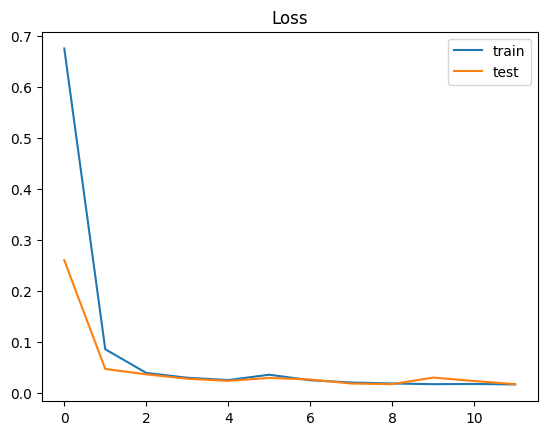

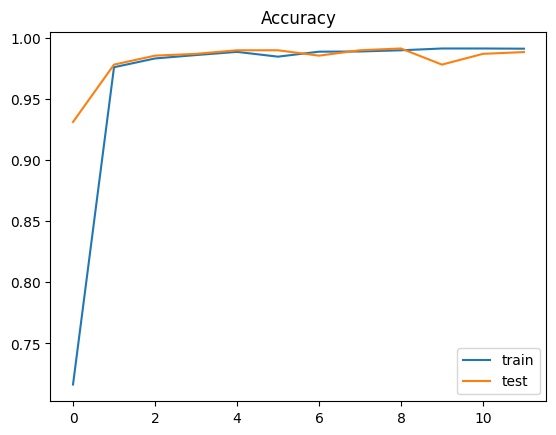

In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();


plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
model.save('lstm.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [ ]:
model.save('lstm.keras')